In [1]:
import pandas as pd
import numpy as np
from time import time
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import copy
from sklearn.preprocessing import StandardScaler
%matplotlib inline
plt.style.use('seaborn')

#Import data
pd.options.display.float_format = "{:.5f}".format
df = pd.read_csv('costsummarydayl2_201905101409.csv')
df.timedim = pd.to_datetime(df.timedim)

#drop useless data
df = df.drop([ "ys_tenant_uuid","ys_billingmonth", "payeraccountid","ys_custom_1","ys_custom_2","ys_custom_3",
              "ys_custom_4","ys_custom_5","ys_custom_6","ys_custom_7","ys_custom_8","ys_custom_9","ys_custom_10",
              "ys_custom_11","ys_custom_12","ys_custom_13","ys_custom_14","ys_custom_15","ys_custom_16",
              "ys_custom_17","ys_custom_18","ys_custom_19","ys_custom_20","run_timestamp", "ys_updatedon"], axis=1)
df = df.drop(["blendedcost", "ys_usagequantity", "ys_reservedusagequantity", "linkedaccountid","ys_role", 
              "ys_customer","ys_costcenter","ys_compliance", "availabilityzone", "ys_instancetype", "ys_os", 
              "ys_tenancytype", "ys_reservedusagetype","usagetype","ys_usagetype","ys_operationgroup"], axis=1)

#mapping perspective to the data
df['perspective'] = np.where(df['ys_operatinghours']=='ANALYTICS-PLATFORM','Analytics Platform',
                    np.where(df['ys_operatinghours']=='FORECASTING-AND-BUDGETING','Forecasting and Budgeting',
                    np.where(df['ys_operatinghours']=='INVENTORY-AND-TAG-MANAGEMENT','Inventory and Tag Management',
                    np.where(df['ys_operatinghours']=='INFRASTRUCTURE','Infrastructure',
                    np.where(df['ys_operatinghours']=='PLATFORM','Infrastructure',     
                    np.where(df['ys_operatinghours']=='WEB-APP','Webapp',
                    np.where(df['ys_operatinghours']=='COST-PROESSING','Cost Processing',
                    np.where(df['ys_operatinghours']=='UTILIZATION-ANALYTICS','Utilization Processing',
                    np.where(df['ys_operatinghours']=='DEVOPS','Devops',
                    np.where(df['ys_operatinghours']=='ANOMALY-DETECTION','Anomaly Detection',
                    np.where(df['ys_operatinghours']=='RECOMMENDATION','Recommendations',
                    np.where(df['ys_operatinghours']=='RECOMMENDATION-PROCESSING','Recommendations','Untagged'))))))))))))

df=df[df.unblendedcost>=0]
df=df[df.unblendedcost<df.unblendedcost.max()]
df=df[df.unblendedcost<=5*df.unblendedcost.std() + df.unblendedcost.mean()]
        
data = df.drop(['usagequantity'],axis=1)
data['ys_region'].fillna('Untagged', inplace=True)
data['operation'].fillna('Untagged', inplace=True)
#data aggregation to per product per perspective level: taking the mode of each feature
df = data.groupby(['timedim','productname','perspective']).agg({'unblendedcost':'sum','ys_usagetypegroup':lambda x: x.value_counts().index[0],'ys_application':lambda x: x.value_counts().index[0],'ys_owner':lambda x: x.value_counts().index[0],
                                                          'ys_cluster':lambda x: x.value_counts().index[0],'operation':lambda x: x.value_counts().index[0],'ys_region':lambda x: x.value_counts().index[0],'ys_environment':lambda x: x.value_counts().index[0],
                                                          'ys_operatinghours':lambda x: x.value_counts().index[0],'ys_project':lambda x: x.value_counts().index[0],'ys_type':lambda x: x.value_counts().index[0],'reservedinstance':lambda x: x.value_counts().index[0],
                                                               'productname':lambda x: x.value_counts().index[0],'perspective':lambda x: x.value_counts().index[0]})
df.shape

(6725, 14)

In [2]:
#one-hot encoding
data = pd.get_dummies(df)
#data['productname']=df.productname
#data['perspective']=df.perspective
encoded = list(data.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))
data.head()

236 total features after one-hot encoding.


unblendedcost  \
timedim    productname                perspective                     
2019-01-01 AWS Budgets                Untagged              0.00000   
           AWS CloudTrail             Untagged              0.00000   
           AWS Cost Explorer          Untagged              0.29000   
           AWS Glue                   Untagged              0.00000   
           AWS Key Management Service Infrastructure        0.03226   

                                                      ys_usagetypegroup_Access  \
timedim    productname                perspective                                
2019-01-01 AWS Budgets                Untagged                               0   
           AWS CloudTrail             Untagged                               0   
           AWS Cost Explorer          Untagged                               0   
           AWS Glue                   Untagged                               0   
           AWS Key Management Service Infrastructure                         0   

                                                      ys_usagetypegroup_Instance  \
timedim    productname                perspective                                  
2019-01-01 AWS Budgets                Untagged                                 0   
           AWS CloudTrail             Untagged                                 0   
           AWS Cost Explorer          Untagged                                 0   
           AWS Glue                   Untagged                                 0   
           AWS Key Management Service Infrastructure                           0   

                                                      ys_usagetypegroup_Network  \
timedim    productname                perspective                                 
2019-01-01 AWS Budgets                Untagged                                0   
           AWS CloudTrail             Untagged                                0   
           AWS Cost Explorer          Untagged                                0   
           AWS Glue                   Untagged                                0   
           AWS Key Management Service Infrastructure                          0   

                                                      ys_usagetypegroup_Others  \
timedim    productname                perspective                                
2019-01-01 AWS Budgets                Untagged                               1   
           AWS CloudTrail             Untagged                               1   
           AWS Cost Explorer          Untagged                               1   
           AWS Glue                   Untagged                               1   
           AWS Key Management Service Infrastructure                         1   

                                                      ys_usagetypegroup_Storage  \
timedim    productname                perspective                                 
2019-01-01 AWS Budgets                Untagged                                0   
           AWS CloudTrail             Untagged                                0   
           AWS Cost Explorer          Untagged                                0   
           AWS Glue                   Untagged                                0   
           AWS Key Management Service Infrastructure                          0   

                                                      ys_usagetypegroup_Unutilized Reservation  \
timedim    productname                perspective                                                
2019-01-01 AWS Budgets                Untagged                                               0   
           AWS CloudTrail             Untagged                                               0   
           AWS Cost Explorer          Untagged                                               0   
           AWS Glue                   Untagged                                               0   
           AWS Key Management Service Infrastructure             

In [3]:
data.shape

(6725, 236)

In [4]:
data.reset_index(inplace=True)
data = data.set_index(['productname','perspective'])
ori_column_num=data.shape[1]-1
ori_column_num

236

In [5]:
#divide the whole dataframe into dictionary, key is the perspective and product, value is the dataframe under this type
prob_pers_index=pd.DataFrame(data.index).drop_duplicates()
data_dict={}
for i in range(len(prob_pers_index)):
    temp_df=data.loc[prob_pers_index.iloc[i,0],:]
    temp_df.set_index('timedim',inplace=True)
    data_dict[prob_pers_index.iloc[i,0]]=temp_df
    #print(prob_pers_index.iloc[i,0],len(data_dict[prob_pers_index.iloc[i,0]]))

C:\Users\leung\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [6]:
#number of timesteps to go back for feature engineering
def shift_series(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        if i>=len(dff):
            # if dataframe is not long enough, fill in with the last time period
            cols.append(dff.shift(len(dff)-1))
        else:
            cols.append(dff.shift(i))
        names += [(dff.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    for i in range(0, n_out):
        if i>=len(dff):
            cols.append(dff.shift(1-len(dff)))
        else:
            cols.append(dff.shift(-i))
        if i == 0:
            names += [(dff.columns[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(dff.columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Single timestep

In [18]:
import sys 
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  
from sklearn.metrics import mean_squared_error,r2_score
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Dropout

In [15]:
t_period=1
multi_time_data_dict={}

# for every type (perspective x product), shift data to prepare features and labels
for key in data_dict.keys():
    temp=shift_series(data_dict[key],t_period,1)
    label_index=['unblendedcost(t-'+str(t_period-i-1)+')' for i in range(t_period-1)]+['unblendedcost(t)']
    label_data=temp.loc[:,label_index]
    label_data.columns=['y(t-'+str(t_period-i-1)+')' for i in range(t_period-1)]+['y(t)']
    temp.drop(temp.iloc[:,-ori_column_num:], axis=1, inplace=True)
    temp=pd.concat([temp,label_data],axis=1)
    #print(reframed_data.columns)
    multi_time_data_dict[key]=temp
    #print(key,len(temp))

In [17]:
i=0
for key in multi_time_data_dict.keys():
    values=multi_time_data_dict[key].values
    train_index = int(values.shape[0]*0.6)+1
    train = values[:train_index, :]
    test = values[train_index:, :]
    sub_train_X, sub_train_y = train[:, :-t_period], train[:, -t_period:]
    sub_test_X, sub_test_y = test[:, :-t_period], test[:, -t_period:]
    sub_train_X = sub_train_X.reshape((sub_train_X.shape[0], t_period, ori_column_num))
    sub_test_X = sub_test_X.reshape((sub_test_X.shape[0], t_period, ori_column_num))
    if i==0:
        train_X,train_y,test_X,test_y=sub_train_X,sub_train_y,sub_test_X,sub_test_y
    else:
        train_X=np.concatenate([train_X,sub_train_X])
        train_y=np.concatenate([train_y,sub_train_y])
        test_X=np.concatenate([test_X,sub_test_X])
        test_y=np.concatenate([test_y,sub_test_y])
    i+=1
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Train on 4023 samples, validate on 2640 samples
Epoch 1/2000
4023/4023 [==============================] - 2s 594us/step - loss: 3908.8488 - val_loss: 6316.5811
Epoch 2/2000
2100/4023 [==============>...............] - ETA: 0s - loss: 5869.7638

C:\Users\leung\Anaconda3\lib\site-packages\keras\callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `mean_squared_error` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4023/4023 [==============================] - 0s 104us/step - loss: 3663.9644 - val_loss: 6170.3494
Epoch 3/2000
4023/4023 [==============================] - 0s 95us/step - loss: 3593.8389 - val_loss: 6112.2462
Epoch 4/2000
4023/4023 [==============================] - 0s 98us/step - loss: 3536.5177 - val_loss: 6060.1351
Epoch 5/2000
4023/4023 [==============================] - 0s 94us/step - loss: 3483.6536 - val_loss: 6011.2235
Epoch 6/2000
4023/4023 [==============================] - 0s 98us/step - loss: 3435.0864 - val_loss: 5964.7613
Epoch 7/2000
4023/4023 [==============================] - 0s 106us/step - loss: 3386.4221 - val_loss: 5920.9436
Epoch 8/2000
4023/4023 [==============================] - 0s 92us/step - loss: 3346.6856 - val_loss: 5880.0903
Epoch 9/2000
4023/4023 [==============================] - 0s 93us/step - loss: 3301.1631 - val_loss: 5841.5707
Epoch 10/2000
4023/4023 [==============================] - 0s 98us/step - loss: 3257.1986 - val_loss: 5795.9602
Epoch 11/20

Epoch 75/2000
4023/4023 [==============================] - 0s 107us/step - loss: 1564.1294 - val_loss: 3979.8701
Epoch 76/2000
4023/4023 [==============================] - 0s 110us/step - loss: 1549.8117 - val_loss: 3969.1132
Epoch 77/2000
4023/4023 [==============================] - 0s 112us/step - loss: 1524.6167 - val_loss: 3950.1093
Epoch 78/2000
4023/4023 [==============================] - 0s 101us/step - loss: 1504.8547 - val_loss: 3921.9765
Epoch 79/2000
4023/4023 [==============================] - 0s 93us/step - loss: 1483.6835 - val_loss: 3903.8729
Epoch 80/2000
4023/4023 [==============================] - 0s 107us/step - loss: 1471.0941 - val_loss: 3894.1151
Epoch 81/2000
4023/4023 [==============================] - 0s 102us/step - loss: 1456.0091 - val_loss: 3864.9878
Epoch 82/2000
4023/4023 [==============================] - 0s 92us/step - loss: 1432.0792 - val_loss: 3848.3840
Epoch 83/2000
4023/4023 [==============================] - 0s 94us/step - loss: 1416.6840 - val_lo

4023/4023 [==============================] - 0s 104us/step - loss: 811.1567 - val_loss: 2982.6963
Epoch 148/2000
4023/4023 [==============================] - 0s 103us/step - loss: 806.4958 - val_loss: 2963.7074
Epoch 149/2000
4023/4023 [==============================] - 0s 105us/step - loss: 828.1883 - val_loss: 3020.5419
Epoch 150/2000
4023/4023 [==============================] - 0s 104us/step - loss: 811.5493 - val_loss: 2956.1066
Epoch 151/2000
4023/4023 [==============================] - 0s 105us/step - loss: 838.0012 - val_loss: 2975.6322
Epoch 152/2000
4023/4023 [==============================] - 0s 98us/step - loss: 806.3107 - val_loss: 2945.8306
Epoch 153/2000
4023/4023 [==============================] - 0s 101us/step - loss: 794.7324 - val_loss: 2946.1257
Epoch 154/2000
4023/4023 [==============================] - 0s 108us/step - loss: 786.1509 - val_loss: 2934.3362
Epoch 155/2000
4023/4023 [==============================] - 0s 103us/step - loss: 785.6289 - val_loss: 2915.6143

4023/4023 [==============================] - 0s 92us/step - loss: 644.0122 - val_loss: 2578.5064
Epoch 221/2000
4023/4023 [==============================] - 0s 90us/step - loss: 682.6516 - val_loss: 2611.6990
Epoch 222/2000
4023/4023 [==============================] - 0s 96us/step - loss: 681.4576 - val_loss: 2591.2818
Epoch 223/2000
4023/4023 [==============================] - 0s 96us/step - loss: 648.3637 - val_loss: 2594.0349
Epoch 224/2000
4023/4023 [==============================] - 0s 99us/step - loss: 664.5998 - val_loss: 2569.0394
Epoch 225/2000
4023/4023 [==============================] - 0s 99us/step - loss: 700.0286 - val_loss: 2583.6087
Epoch 226/2000
4023/4023 [==============================] - 0s 102us/step - loss: 632.2030 - val_loss: 2556.6036
Epoch 227/2000
4023/4023 [==============================] - 0s 96us/step - loss: 603.0831 - val_loss: 2534.9719
Epoch 228/2000
4023/4023 [==============================] - 0s 98us/step - loss: 711.1070 - val_loss: 2583.0277
Epoch 

4023/4023 [==============================] - 0s 95us/step - loss: 495.1099 - val_loss: 2176.8985
Epoch 294/2000
4023/4023 [==============================] - 0s 89us/step - loss: 529.6310 - val_loss: 2231.2625
Epoch 295/2000
4023/4023 [==============================] - 0s 89us/step - loss: 501.5855 - val_loss: 2155.8698
Epoch 296/2000
4023/4023 [==============================] - 0s 90us/step - loss: 471.7454 - val_loss: 2264.6838
Epoch 297/2000
4023/4023 [==============================] - 0s 92us/step - loss: 486.8848 - val_loss: 2131.6582
Epoch 298/2000
4023/4023 [==============================] - 0s 91us/step - loss: 508.8238 - val_loss: 2242.6961
Epoch 299/2000
4023/4023 [==============================] - 0s 89us/step - loss: 463.9626 - val_loss: 2148.3560
Epoch 300/2000
4023/4023 [==============================] - 0s 90us/step - loss: 505.9324 - val_loss: 2183.5018
Epoch 301/2000
4023/4023 [==============================] - 0s 90us/step - loss: 484.8029 - val_loss: 2152.7351
Epoch 3

4023/4023 [==============================] - 0s 96us/step - loss: 447.2029 - val_loss: 2074.9558
Epoch 367/2000
4023/4023 [==============================] - 0s 93us/step - loss: 516.0782 - val_loss: 2302.3721
Epoch 368/2000
4023/4023 [==============================] - 0s 93us/step - loss: 613.3518 - val_loss: 2052.3476
Epoch 369/2000
4023/4023 [==============================] - 0s 99us/step - loss: 493.0197 - val_loss: 2024.7088
Epoch 370/2000
4023/4023 [==============================] - 0s 90us/step - loss: 419.6790 - val_loss: 2037.9033
Epoch 371/2000
4023/4023 [==============================] - 0s 90us/step - loss: 483.5960 - val_loss: 1958.6750
Epoch 372/2000
4023/4023 [==============================] - 0s 91us/step - loss: 465.8299 - val_loss: 1976.4790
Epoch 373/2000
4023/4023 [==============================] - 0s 92us/step - loss: 450.9475 - val_loss: 1981.0558
Epoch 374/2000
4023/4023 [==============================] - 0s 89us/step - loss: 448.1001 - val_loss: 2089.3558
Epoch 3

4023/4023 [==============================] - 0s 105us/step - loss: 484.5271 - val_loss: 1876.9681
Epoch 440/2000
4023/4023 [==============================] - 0s 110us/step - loss: 456.0576 - val_loss: 1914.4036
Epoch 441/2000
4023/4023 [==============================] - 0s 98us/step - loss: 500.1911 - val_loss: 1963.3940
Epoch 442/2000
4023/4023 [==============================] - 0s 103us/step - loss: 448.0377 - val_loss: 1796.9631
Epoch 443/2000
4023/4023 [==============================] - 0s 102us/step - loss: 420.0330 - val_loss: 1861.0696
Epoch 444/2000
4023/4023 [==============================] - 0s 95us/step - loss: 382.1262 - val_loss: 1811.2972
Epoch 445/2000
4023/4023 [==============================] - 0s 94us/step - loss: 428.7062 - val_loss: 2015.1267
Epoch 446/2000
4023/4023 [==============================] - 0s 95us/step - loss: 503.6241 - val_loss: 1919.8198
Epoch 447/2000
4023/4023 [==============================] - 0s 95us/step - loss: 414.6544 - val_loss: 1849.9504
Epo

4023/4023 [==============================] - 0s 99us/step - loss: 402.5539 - val_loss: 1931.2928
Epoch 513/2000
4023/4023 [==============================] - 0s 94us/step - loss: 562.6079 - val_loss: 1995.2930
Epoch 514/2000
4023/4023 [==============================] - 0s 99us/step - loss: 462.8223 - val_loss: 1911.3691
Epoch 515/2000
4023/4023 [==============================] - 0s 103us/step - loss: 441.7081 - val_loss: 1879.2134
Epoch 516/2000
4023/4023 [==============================] - 0s 95us/step - loss: 452.0168 - val_loss: 1817.2437
Epoch 517/2000
4023/4023 [==============================] - 0s 96us/step - loss: 398.2002 - val_loss: 1789.2982
Epoch 518/2000
4023/4023 [==============================] - 0s 107us/step - loss: 430.3642 - val_loss: 1768.9819
Epoch 519/2000
4023/4023 [==============================] - 0s 95us/step - loss: 449.3390 - val_loss: 1922.3818
Epoch 520/2000
4023/4023 [==============================] - 0s 96us/step - loss: 500.6191 - val_loss: 1800.9419
Epoch

4023/4023 [==============================] - 0s 92us/step - loss: 375.4769 - val_loss: 1653.6240
Epoch 586/2000
4023/4023 [==============================] - 0s 89us/step - loss: 363.6813 - val_loss: 1647.8928
Epoch 587/2000
4023/4023 [==============================] - 0s 91us/step - loss: 451.1870 - val_loss: 1970.0904
Epoch 588/2000
4023/4023 [==============================] - 0s 92us/step - loss: 558.1884 - val_loss: 1680.2015
Epoch 589/2000
4023/4023 [==============================] - 0s 91us/step - loss: 620.8919 - val_loss: 1639.9867
Epoch 590/2000
4023/4023 [==============================] - 0s 90us/step - loss: 339.4166 - val_loss: 1563.6948
Epoch 591/2000
4023/4023 [==============================] - 0s 90us/step - loss: 399.8117 - val_loss: 1677.5605
Epoch 592/2000
4023/4023 [==============================] - 0s 93us/step - loss: 440.9466 - val_loss: 1567.5495
Epoch 593/2000
4023/4023 [==============================] - 0s 90us/step - loss: 366.6332 - val_loss: 1589.8031
Epoch 5

4023/4023 [==============================] - 0s 91us/step - loss: 306.7510 - val_loss: 1502.0184
Epoch 659/2000
4023/4023 [==============================] - 0s 94us/step - loss: 320.7073 - val_loss: 1756.6202
Epoch 660/2000
4023/4023 [==============================] - 0s 90us/step - loss: 415.3583 - val_loss: 1538.7754
Epoch 661/2000
4023/4023 [==============================] - 0s 90us/step - loss: 376.1979 - val_loss: 1694.3501
Epoch 662/2000
4023/4023 [==============================] - 0s 91us/step - loss: 412.6588 - val_loss: 1540.0486
Epoch 663/2000
4023/4023 [==============================] - 0s 91us/step - loss: 368.3412 - val_loss: 1647.0108
Epoch 664/2000
4023/4023 [==============================] - 0s 91us/step - loss: 372.3855 - val_loss: 1525.9021
Epoch 665/2000
4023/4023 [==============================] - 0s 90us/step - loss: 365.8585 - val_loss: 1599.8221
Epoch 666/2000
4023/4023 [==============================] - 0s 103us/step - loss: 404.4199 - val_loss: 1536.7950
Epoch 

4023/4023 [==============================] - 0s 101us/step - loss: 500.1039 - val_loss: 1832.9301
Epoch 732/2000
4023/4023 [==============================] - 0s 94us/step - loss: 538.4637 - val_loss: 1692.7887
Epoch 733/2000
4023/4023 [==============================] - 0s 94us/step - loss: 555.3651 - val_loss: 1892.9577
Epoch 734/2000
4023/4023 [==============================] - 0s 95us/step - loss: 542.9848 - val_loss: 1645.8483
Epoch 735/2000
4023/4023 [==============================] - 0s 95us/step - loss: 540.2980 - val_loss: 1823.7102
Epoch 736/2000
4023/4023 [==============================] - 0s 91us/step - loss: 534.7185 - val_loss: 1796.0124
Epoch 737/2000
4023/4023 [==============================] - 0s 90us/step - loss: 629.7474 - val_loss: 2028.1916
Epoch 738/2000
4023/4023 [==============================] - 0s 90us/step - loss: 752.6149 - val_loss: 1861.5197
Epoch 739/2000
4023/4023 [==============================] - 0s 89us/step - loss: 657.9792 - val_loss: 2069.8844
Epoch 

Epoch 804/2000
4023/4023 [==============================] - 0s 90us/step - loss: 489.4685 - val_loss: 2123.6701
Epoch 805/2000
4023/4023 [==============================] - 0s 91us/step - loss: 481.7128 - val_loss: 2112.9143
Epoch 806/2000
4023/4023 [==============================] - 0s 90us/step - loss: 502.6858 - val_loss: 2100.6028
Epoch 807/2000
4023/4023 [==============================] - 0s 99us/step - loss: 520.4226 - val_loss: 2123.1863
Epoch 808/2000
4023/4023 [==============================] - 0s 96us/step - loss: 561.0576 - val_loss: 2161.7898
Epoch 809/2000
4023/4023 [==============================] - 0s 105us/step - loss: 510.5036 - val_loss: 2213.6543
Epoch 810/2000
4023/4023 [==============================] - 0s 96us/step - loss: 586.0842 - val_loss: 2146.6612
Epoch 811/2000
4023/4023 [==============================] - 0s 100us/step - loss: 502.6616 - val_loss: 2039.7761
Epoch 812/2000
4023/4023 [==============================] - 0s 98us/step - loss: 552.5088 - val_loss: 

4023/4023 [==============================] - 0s 91us/step - loss: 525.6933 - val_loss: 2193.4094
Epoch 878/2000
4023/4023 [==============================] - 0s 91us/step - loss: 542.9430 - val_loss: 2000.0157
Epoch 879/2000
4023/4023 [==============================] - 0s 90us/step - loss: 537.5731 - val_loss: 2046.3801
Epoch 880/2000
4023/4023 [==============================] - 0s 90us/step - loss: 476.4045 - val_loss: 1906.2574
Epoch 881/2000
4023/4023 [==============================] - 0s 90us/step - loss: 485.3925 - val_loss: 1967.8856
Epoch 882/2000
4023/4023 [==============================] - 0s 93us/step - loss: 488.0670 - val_loss: 1984.3602
Epoch 883/2000
4023/4023 [==============================] - 0s 90us/step - loss: 474.8473 - val_loss: 2024.4253
Epoch 884/2000
4023/4023 [==============================] - 0s 90us/step - loss: 505.7701 - val_loss: 1997.5726
Epoch 885/2000
4023/4023 [==============================] - 0s 91us/step - loss: 447.9363 - val_loss: 2056.5532
Epoch 8

4023/4023 [==============================] - 0s 92us/step - loss: 432.7303 - val_loss: 1897.3778
Epoch 951/2000
4023/4023 [==============================] - 0s 92us/step - loss: 447.3527 - val_loss: 1990.5881
Epoch 952/2000
4023/4023 [==============================] - 0s 91us/step - loss: 469.0099 - val_loss: 1961.0981
Epoch 953/2000
4023/4023 [==============================] - 0s 95us/step - loss: 443.4423 - val_loss: 1904.7536
Epoch 954/2000
4023/4023 [==============================] - 0s 99us/step - loss: 435.5024 - val_loss: 1871.9482
Epoch 955/2000
4023/4023 [==============================] - 0s 89us/step - loss: 436.3184 - val_loss: 1850.1994
Epoch 956/2000
4023/4023 [==============================] - 0s 94us/step - loss: 420.4691 - val_loss: 1810.0299
Epoch 957/2000
4023/4023 [==============================] - 0s 90us/step - loss: 411.8283 - val_loss: 1785.4179
Epoch 958/2000
4023/4023 [==============================] - 0s 100us/step - loss: 443.3273 - val_loss: 1715.5191
Epoch 

Epoch 1023/2000
4023/4023 [==============================] - 0s 95us/step - loss: 524.9893 - val_loss: 2030.3265
Epoch 1024/2000
4023/4023 [==============================] - 0s 97us/step - loss: 505.8338 - val_loss: 1947.5191
Epoch 1025/2000
4023/4023 [==============================] - 0s 103us/step - loss: 477.2267 - val_loss: 1949.9809
Epoch 1026/2000
4023/4023 [==============================] - 0s 94us/step - loss: 486.5059 - val_loss: 1890.6431
Epoch 1027/2000
4023/4023 [==============================] - 0s 95us/step - loss: 538.7627 - val_loss: 1889.4013
Epoch 1028/2000
4023/4023 [==============================] - 0s 102us/step - loss: 505.6883 - val_loss: 1914.8065
Epoch 1029/2000
4023/4023 [==============================] - 0s 94us/step - loss: 515.7518 - val_loss: 1872.5604
Epoch 1030/2000
4023/4023 [==============================] - 0s 95us/step - loss: 509.4685 - val_loss: 1838.7435
Epoch 1031/2000
4023/4023 [==============================] - 0s 91us/step - loss: 453.6699 - v

4023/4023 [==============================] - 0s 93us/step - loss: 349.0415 - val_loss: 1433.8927
Epoch 1096/2000
4023/4023 [==============================] - 0s 92us/step - loss: 375.3345 - val_loss: 1464.3552
Epoch 1097/2000
4023/4023 [==============================] - 0s 91us/step - loss: 296.8028 - val_loss: 1401.5318
Epoch 1098/2000
4023/4023 [==============================] - 0s 89us/step - loss: 351.8058 - val_loss: 1438.0542
Epoch 1099/2000
4023/4023 [==============================] - 0s 90us/step - loss: 339.3666 - val_loss: 1411.5177
Epoch 1100/2000
4023/4023 [==============================] - 0s 91us/step - loss: 292.1752 - val_loss: 1392.6280
Epoch 1101/2000
4023/4023 [==============================] - 0s 99us/step - loss: 309.2923 - val_loss: 1422.6036
Epoch 1102/2000
4023/4023 [==============================] - 0s 97us/step - loss: 347.7686 - val_loss: 1389.0956
Epoch 1103/2000
4023/4023 [==============================] - 0s 95us/step - loss: 310.6657 - val_loss: 1464.5831

4023/4023 [==============================] - 0s 90us/step - loss: 340.5771 - val_loss: 1449.9072
Epoch 1168/2000
4023/4023 [==============================] - 0s 91us/step - loss: 437.2176 - val_loss: 1516.6873
Epoch 1169/2000
4023/4023 [==============================] - 0s 89us/step - loss: 337.4049 - val_loss: 1461.9393
Epoch 1170/2000
4023/4023 [==============================] - 0s 89us/step - loss: 458.3865 - val_loss: 1510.3526
Epoch 1171/2000
4023/4023 [==============================] - 0s 91us/step - loss: 355.8652 - val_loss: 1469.8972
Epoch 1172/2000
4023/4023 [==============================] - 0s 92us/step - loss: 340.5960 - val_loss: 1460.6651
Epoch 1173/2000
4023/4023 [==============================] - 0s 90us/step - loss: 356.0509 - val_loss: 1437.5093
Epoch 1174/2000
4023/4023 [==============================] - 0s 91us/step - loss: 336.1417 - val_loss: 1459.6337
Epoch 1175/2000
4023/4023 [==============================] - 0s 91us/step - loss: 336.6583 - val_loss: 1436.2765

4023/4023 [==============================] - 0s 94us/step - loss: 338.7561 - val_loss: 1397.4984
Epoch 1240/2000
4023/4023 [==============================] - 0s 96us/step - loss: 347.0744 - val_loss: 1312.9070
Epoch 1241/2000
4023/4023 [==============================] - 0s 94us/step - loss: 406.3015 - val_loss: 1399.5267
Epoch 1242/2000
4023/4023 [==============================] - 0s 90us/step - loss: 312.2918 - val_loss: 1365.0876
Epoch 1243/2000
4023/4023 [==============================] - 0s 91us/step - loss: 362.3957 - val_loss: 1365.1088
Epoch 1244/2000
4023/4023 [==============================] - 0s 90us/step - loss: 326.5643 - val_loss: 1339.3770
Epoch 1245/2000
4023/4023 [==============================] - 0s 90us/step - loss: 322.0375 - val_loss: 1354.9863
Epoch 1246/2000
4023/4023 [==============================] - 0s 93us/step - loss: 316.7477 - val_loss: 1400.6645
Epoch 1247/2000
4023/4023 [==============================] - 0s 93us/step - loss: 360.3815 - val_loss: 1355.7125

4023/4023 [==============================] - 0s 92us/step - loss: 461.2937 - val_loss: 1927.5743
Epoch 1312/2000
4023/4023 [==============================] - 0s 106us/step - loss: 452.9506 - val_loss: 1926.0296
Epoch 1313/2000
4023/4023 [==============================] - 0s 95us/step - loss: 486.3000 - val_loss: 1942.4866
Epoch 1314/2000
4023/4023 [==============================] - 0s 99us/step - loss: 498.1165 - val_loss: 1916.2633
Epoch 1315/2000
4023/4023 [==============================] - 0s 100us/step - loss: 478.5609 - val_loss: 1909.1852
Epoch 1316/2000
4023/4023 [==============================] - 0s 96us/step - loss: 507.6543 - val_loss: 1908.6746
Epoch 1317/2000
4023/4023 [==============================] - 0s 94us/step - loss: 464.8042 - val_loss: 1984.7913
Epoch 1318/2000
4023/4023 [==============================] - 0s 98us/step - loss: 532.5736 - val_loss: 1889.1726
Epoch 1319/2000
4023/4023 [==============================] - 0s 98us/step - loss: 479.4029 - val_loss: 1864.89

4023/4023 [==============================] - 0s 91us/step - loss: 396.7315 - val_loss: 1542.1067
Epoch 1384/2000
4023/4023 [==============================] - 0s 92us/step - loss: 340.3441 - val_loss: 1603.7744
Epoch 1385/2000
4023/4023 [==============================] - 0s 90us/step - loss: 407.4944 - val_loss: 1565.6033
Epoch 1386/2000
4023/4023 [==============================] - 0s 92us/step - loss: 435.8386 - val_loss: 1541.3244
Epoch 1387/2000
4023/4023 [==============================] - 0s 91us/step - loss: 390.5799 - val_loss: 1526.6739
Epoch 1388/2000
4023/4023 [==============================] - 0s 91us/step - loss: 447.7050 - val_loss: 1526.9216
Epoch 1389/2000
4023/4023 [==============================] - 0s 91us/step - loss: 380.1618 - val_loss: 1635.0789
Epoch 1390/2000
4023/4023 [==============================] - 0s 91us/step - loss: 437.0366 - val_loss: 1562.0315
Epoch 1391/2000
4023/4023 [==============================] - 0s 93us/step - loss: 407.1444 - val_loss: 1549.4442

4023/4023 [==============================] - 0s 91us/step - loss: 340.2818 - val_loss: 1465.8559
Epoch 1456/2000
4023/4023 [==============================] - 0s 89us/step - loss: 360.9601 - val_loss: 1474.3378
Epoch 1457/2000
4023/4023 [==============================] - 0s 91us/step - loss: 383.2616 - val_loss: 1516.3196
Epoch 1458/2000
4023/4023 [==============================] - 0s 90us/step - loss: 375.0897 - val_loss: 1497.7879
Epoch 1459/2000
4023/4023 [==============================] - 0s 92us/step - loss: 361.4317 - val_loss: 1521.9303
Epoch 1460/2000
4023/4023 [==============================] - 0s 90us/step - loss: 340.5364 - val_loss: 1469.5788
Epoch 1461/2000
4023/4023 [==============================] - 0s 90us/step - loss: 332.9689 - val_loss: 1458.0632
Epoch 1462/2000
4023/4023 [==============================] - 0s 91us/step - loss: 357.4575 - val_loss: 1430.9304
Epoch 1463/2000
4023/4023 [==============================] - 0s 90us/step - loss: 440.5001 - val_loss: 1498.6735

4023/4023 [==============================] - 0s 97us/step - loss: 597.8315 - val_loss: 2062.4214
Epoch 1528/2000
4023/4023 [==============================] - 0s 97us/step - loss: 591.7606 - val_loss: 2088.5945
Epoch 1529/2000
4023/4023 [==============================] - 0s 100us/step - loss: 597.0576 - val_loss: 2109.8852
Epoch 1530/2000
4023/4023 [==============================] - 0s 97us/step - loss: 576.8580 - val_loss: 1995.0597
Epoch 1531/2000
4023/4023 [==============================] - 0s 97us/step - loss: 635.0526 - val_loss: 2077.6145
Epoch 1532/2000
4023/4023 [==============================] - 0s 94us/step - loss: 530.8809 - val_loss: 2012.1572
Epoch 1533/2000
4023/4023 [==============================] - 0s 95us/step - loss: 579.6066 - val_loss: 2067.5076
Epoch 1534/2000
4023/4023 [==============================] - 0s 95us/step - loss: 532.7868 - val_loss: 2024.4809
Epoch 1535/2000
4023/4023 [==============================] - 0s 96us/step - loss: 510.2678 - val_loss: 2115.569

4023/4023 [==============================] - 0s 91us/step - loss: 594.8929 - val_loss: 2089.4679
Epoch 1600/2000
4023/4023 [==============================] - 0s 91us/step - loss: 537.3602 - val_loss: 2183.4966
Epoch 1601/2000
4023/4023 [==============================] - 0s 92us/step - loss: 563.5836 - val_loss: 2141.9049
Epoch 1602/2000
4023/4023 [==============================] - 0s 89us/step - loss: 532.9992 - val_loss: 2129.9399
Epoch 1603/2000
4023/4023 [==============================] - 0s 100us/step - loss: 524.9384 - val_loss: 2135.7186
Epoch 1604/2000
4023/4023 [==============================] - 0s 90us/step - loss: 508.6394 - val_loss: 2131.5460
Epoch 1605/2000
4023/4023 [==============================] - 0s 92us/step - loss: 524.1952 - val_loss: 2113.7750
Epoch 1606/2000
4023/4023 [==============================] - 0s 97us/step - loss: 445.9401 - val_loss: 2061.7220
Epoch 1607/2000
4023/4023 [==============================] - 0s 95us/step - loss: 579.1796 - val_loss: 2169.682

4023/4023 [==============================] - 0s 92us/step - loss: 551.6106 - val_loss: 2208.2787
Epoch 1672/2000
4023/4023 [==============================] - 0s 90us/step - loss: 503.3654 - val_loss: 2140.5478
Epoch 1673/2000
4023/4023 [==============================] - 0s 91us/step - loss: 459.2921 - val_loss: 2178.6934
Epoch 1674/2000
4023/4023 [==============================] - 0s 91us/step - loss: 490.8599 - val_loss: 2135.1002
Epoch 1675/2000
4023/4023 [==============================] - 0s 92us/step - loss: 546.4092 - val_loss: 2080.2653
Epoch 1676/2000
4023/4023 [==============================] - 0s 91us/step - loss: 553.8476 - val_loss: 2172.0382
Epoch 1677/2000
4023/4023 [==============================] - 0s 91us/step - loss: 507.7763 - val_loss: 2083.2866
Epoch 1678/2000
4023/4023 [==============================] - 0s 92us/step - loss: 486.4463 - val_loss: 2165.2993
Epoch 1679/2000
4023/4023 [==============================] - 0s 91us/step - loss: 519.4873 - val_loss: 2152.3552

4023/4023 [==============================] - 0s 97us/step - loss: 453.0152 - val_loss: 2116.8077
Epoch 1744/2000
4023/4023 [==============================] - 0s 93us/step - loss: 472.2735 - val_loss: 1973.1892
Epoch 1745/2000
4023/4023 [==============================] - 0s 95us/step - loss: 462.8951 - val_loss: 2042.7898
Epoch 1746/2000
4023/4023 [==============================] - 0s 96us/step - loss: 436.0651 - val_loss: 1985.6668
Epoch 1747/2000
4023/4023 [==============================] - 0s 90us/step - loss: 449.2538 - val_loss: 2061.5422
Epoch 1748/2000
4023/4023 [==============================] - 0s 91us/step - loss: 535.5588 - val_loss: 2102.5564
Epoch 1749/2000
4023/4023 [==============================] - 0s 91us/step - loss: 493.7678 - val_loss: 1984.8205
Epoch 1750/2000
4023/4023 [==============================] - 0s 91us/step - loss: 470.2959 - val_loss: 1967.6014
Epoch 1751/2000
4023/4023 [==============================] - 0s 90us/step - loss: 404.0423 - val_loss: 1953.2026

4023/4023 [==============================] - 2s 537us/step - loss: 434.3476 - val_loss: 1758.0795
Epoch 1816/2000
4023/4023 [==============================] - 2s 508us/step - loss: 456.0544 - val_loss: 1776.9360
Epoch 1817/2000
4023/4023 [==============================] - 2s 434us/step - loss: 437.2320 - val_loss: 1787.4174
Epoch 1818/2000
4023/4023 [==============================] - 2s 420us/step - loss: 402.2371 - val_loss: 1815.7503
Epoch 1819/2000
4023/4023 [==============================] - 1s 363us/step - loss: 420.1544 - val_loss: 1970.1445
Epoch 1820/2000
4023/4023 [==============================] - 1s 350us/step - loss: 483.1443 - val_loss: 1933.4368
Epoch 1821/2000
4023/4023 [==============================] - 1s 302us/step - loss: 427.3329 - val_loss: 1747.4862
Epoch 1822/2000
4023/4023 [==============================] - 1s 262us/step - loss: 461.5740 - val_loss: 1843.2610
Epoch 1823/2000
4023/4023 [==============================] - 1s 237us/step - loss: 476.3004 - val_loss: 

4023/4023 [==============================] - 0s 92us/step - loss: 436.2211 - val_loss: 1612.3469
Epoch 1888/2000
4023/4023 [==============================] - 0s 107us/step - loss: 379.5796 - val_loss: 1651.7972
Epoch 1889/2000
4023/4023 [==============================] - 0s 100us/step - loss: 409.8080 - val_loss: 1684.0283
Epoch 1890/2000
4023/4023 [==============================] - 0s 98us/step - loss: 417.6898 - val_loss: 1586.2746
Epoch 1891/2000
4023/4023 [==============================] - 1s 173us/step - loss: 401.5913 - val_loss: 1623.8346
Epoch 1892/2000
4023/4023 [==============================] - 1s 132us/step - loss: 374.7484 - val_loss: 1673.9911
Epoch 1893/2000
4023/4023 [==============================] - 0s 91us/step - loss: 379.1349 - val_loss: 1675.0099
Epoch 1894/2000
4023/4023 [==============================] - 0s 94us/step - loss: 388.0177 - val_loss: 1626.9511
Epoch 1895/2000
4023/4023 [==============================] - 0s 111us/step - loss: 397.0487 - val_loss: 1625

4023/4023 [==============================] - 0s 97us/step - loss: 343.6358 - val_loss: 1518.0737
Epoch 1960/2000
4023/4023 [==============================] - 0s 93us/step - loss: 401.2253 - val_loss: 1509.7411
Epoch 1961/2000
4023/4023 [==============================] - 0s 89us/step - loss: 351.2520 - val_loss: 1496.7008
Epoch 1962/2000
4023/4023 [==============================] - 0s 93us/step - loss: 318.0951 - val_loss: 1498.9848
Epoch 1963/2000
4023/4023 [==============================] - 0s 91us/step - loss: 305.5580 - val_loss: 1505.6971
Epoch 1964/2000
4023/4023 [==============================] - 0s 92us/step - loss: 318.0582 - val_loss: 1581.7207
Epoch 1965/2000
4023/4023 [==============================] - 0s 90us/step - loss: 396.2090 - val_loss: 1544.5208
Epoch 1966/2000
4023/4023 [==============================] - 0s 92us/step - loss: 381.0194 - val_loss: 1508.9902
Epoch 1967/2000
4023/4023 [==============================] - 0s 89us/step - loss: 355.7058 - val_loss: 1558.1547

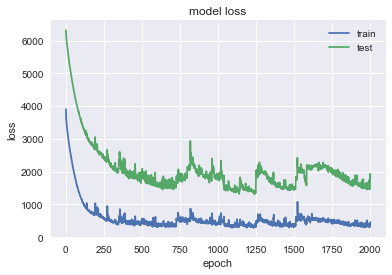

In [19]:
#stacked LSTMs
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(t_period))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.003))
# fit model
es = keras.callbacks.EarlyStopping(monitor='mean_squared_error', mode='min', verbose=1, patience=5)

history = model.fit(train_X, train_y, epochs=2000, batch_size=100, validation_data=(test_X, test_y), callbacks=[es], verbose=1, shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

def standardized_rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))
 
yhat = model.predict(test_X, verbose=0)
mape = mean_absolute_percentage_error(test_y, yhat)
rmse = standardized_rmse(test_y, yhat)
print('MAPE: %.3f' % mape)
print('Test Standardized RMSE: %.3f' % rmse)

MAPE: 2.827
Test Standardized RMSE: 42.546


# Multi-timestep

In [7]:
t_period=7
multi_time_data_dict={}

# for every type (perspective x product), shift data to prepare features and labels
for key in data_dict.keys():
    temp=shift_series(data_dict[key],t_period,1)
    label_index=['unblendedcost(t-'+str(t_period-i-1)+')' for i in range(t_period-1)]+['unblendedcost(t)']
    label_data=temp.loc[:,label_index]
    label_data.columns=['y(t-'+str(t_period-i-1)+')' for i in range(t_period-1)]+['y(t)']
    temp.drop(temp.iloc[:,-ori_column_num:], axis=1, inplace=True)
    temp=pd.concat([temp,label_data],axis=1)
    #print(reframed_data.columns)
    multi_time_data_dict[key]=temp
    #print(key,len(temp))

In [8]:
i=0
for key in multi_time_data_dict.keys():
    values=multi_time_data_dict[key].values
    train_index = int(values.shape[0]*0.6)+1
    train = values[:train_index, :]
    test = values[train_index:, :]
    sub_train_X, sub_train_y = train[:, :-t_period], train[:, -t_period:]
    sub_test_X, sub_test_y = test[:, :-t_period], test[:, -t_period:]
    sub_train_X = sub_train_X.reshape((sub_train_X.shape[0], t_period, ori_column_num))
    sub_test_X = sub_test_X.reshape((sub_test_X.shape[0], t_period, ori_column_num))
    if i==0:
        train_X,train_y,test_X,test_y=sub_train_X,sub_train_y,sub_test_X,sub_test_y
    else:
        train_X=np.concatenate([train_X,sub_train_X])
        train_y=np.concatenate([train_y,sub_train_y])
        test_X=np.concatenate([test_X,sub_test_X])
        test_y=np.concatenate([test_y,sub_test_y])
    i+=1
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(73, 7, 236) (73, 7) (48, 7, 236) (48, 7)
(147, 7, 236) (147, 7) (96, 7, 236) (96, 7)
(217, 7, 236) (217, 7) (141, 7, 236) (141, 7)
(291, 7, 236) (291, 7) (189, 7, 236) (189, 7)
(365, 7, 236) (365, 7) (237, 7, 236) (237, 7)
(439, 7, 236) (439, 7) (285, 7, 236) (285, 7)
(502, 7, 236) (502, 7) (326, 7, 236) (326, 7)
(576, 7, 236) (576, 7) (374, 7, 236) (374, 7)
(644, 7, 236) (644, 7) (419, 7, 236) (419, 7)
(684, 7, 236) (684, 7) (444, 7, 236) (444, 7)
(758, 7, 236) (758, 7) (492, 7, 236) (492, 7)
(831, 7, 236) (831, 7) (539, 7, 236) (539, 7)
(905, 7, 236) (905, 7) (587, 7, 236) (587, 7)
(978, 7, 236) (978, 7) (634, 7, 236) (634, 7)
(980, 7, 236) (980, 7) (634, 7, 236) (634, 7)
(1043, 7, 236) (1043, 7) (675, 7, 236) (675, 7)
(1117, 7, 236) (1117, 7) (723, 7, 236) (723, 7)
(1191, 7, 236) (1191, 7) (771, 7, 236) (771, 7)
(1265, 7, 236) (1265, 7) (819, 7, 236) (819, 7)
(1339, 7, 236) (1339, 7) (867, 7, 236) (867, 7)
(1340, 7, 236) (1340, 7) (867, 7, 236) (867, 7)
(1414, 7, 236) (1414, 7) (91

W1012 16:53:06.866786 14676 deprecation_wrapper.py:119] From C:\Users\leung\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1012 16:53:06.937597 14676 deprecation_wrapper.py:119] From C:\Users\leung\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1012 16:53:06.951558 14676 deprecation_wrapper.py:119] From C:\Users\leung\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1012 16:53:07.283671 14676 deprecation_wrapper.py:119] From C:\Users\leung\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1012 16:53:07.317579 14676 deprecation.py:506

Train on 3824 samples, validate on 2470 samples
Epoch 1/2000
3824/3824 [==============================] - 3s 902us/step - loss: 4064.5431 - val_loss: 6591.2957
Epoch 2/2000
 700/3824 [====>.........................] - ETA: 0s - loss: 0.3556

C:\Users\leung\Anaconda3\lib\site-packages\keras\callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `mean_squared_error` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


3824/3824 [==============================] - 1s 362us/step - loss: 3927.3768 - val_loss: 6499.2521
Epoch 3/2000
3824/3824 [==============================] - 1s 326us/step - loss: 3845.4030 - val_loss: 6425.1193
Epoch 4/2000
3824/3824 [==============================] - 1s 348us/step - loss: 3775.1014 - val_loss: 6357.8954
Epoch 5/2000
3824/3824 [==============================] - 1s 343us/step - loss: 3708.5746 - val_loss: 6294.7834
Epoch 6/2000
3824/3824 [==============================] - 1s 347us/step - loss: 3646.9190 - val_loss: 6234.3321
Epoch 7/2000
3824/3824 [==============================] - 1s 332us/step - loss: 3585.7377 - val_loss: 6177.3103
Epoch 8/2000
3824/3824 [==============================] - 1s 338us/step - loss: 3532.9481 - val_loss: 6121.1782
Epoch 9/2000
3824/3824 [==============================] - 1s 357us/step - loss: 3476.8510 - val_loss: 6070.3005
Epoch 10/2000
3824/3824 [==============================] - 1s 339us/step - loss: 3423.5860 - val_loss: 6012.5231
Epoc

3824/3824 [==============================] - 2s 393us/step - loss: 1481.0505 - val_loss: 3862.9326
Epoch 75/2000
3824/3824 [==============================] - 1s 380us/step - loss: 1450.8072 - val_loss: 3844.4104
Epoch 76/2000
3824/3824 [==============================] - 1s 357us/step - loss: 1441.0926 - val_loss: 3817.1546
Epoch 77/2000
3824/3824 [==============================] - 1s 378us/step - loss: 1423.7353 - val_loss: 3804.0364
Epoch 78/2000
3824/3824 [==============================] - 1s 339us/step - loss: 1408.4374 - val_loss: 3775.2750
Epoch 79/2000
3824/3824 [==============================] - 1s 349us/step - loss: 1382.7640 - val_loss: 3758.0762
Epoch 80/2000
3824/3824 [==============================] - 1s 342us/step - loss: 1359.0496 - val_loss: 3735.7558
Epoch 81/2000
3824/3824 [==============================] - 1s 342us/step - loss: 1348.5985 - val_loss: 3719.4913
Epoch 82/2000
3824/3824 [==============================] - 1s 344us/step - loss: 1336.2724 - val_loss: 3694.37

3824/3824 [==============================] - 1s 369us/step - loss: 805.2595 - val_loss: 2898.8493
Epoch 147/2000
3824/3824 [==============================] - 1s 370us/step - loss: 833.3744 - val_loss: 2893.7531
Epoch 148/2000
3824/3824 [==============================] - 1s 356us/step - loss: 799.9238 - val_loss: 2903.9001
Epoch 149/2000
3824/3824 [==============================] - 1s 356us/step - loss: 800.1667 - val_loss: 2957.5457
Epoch 150/2000
3824/3824 [==============================] - 1s 365us/step - loss: 835.4056 - val_loss: 2936.7766
Epoch 151/2000
3824/3824 [==============================] - 1s 380us/step - loss: 841.1839 - val_loss: 2925.3143
Epoch 152/2000
3824/3824 [==============================] - 1s 365us/step - loss: 804.9657 - val_loss: 2815.7214
Epoch 153/2000
3824/3824 [==============================] - 2s 403us/step - loss: 783.0561 - val_loss: 2797.5436
Epoch 154/2000
3824/3824 [==============================] - 1s 371us/step - loss: 760.9909 - val_loss: 2787.447

3824/3824 [==============================] - 1s 339us/step - loss: 534.7608 - val_loss: 2296.9996
Epoch 219/2000
3824/3824 [==============================] - 1s 342us/step - loss: 535.4405 - val_loss: 2281.2650
Epoch 220/2000
3824/3824 [==============================] - 1s 346us/step - loss: 538.1083 - val_loss: 2306.5102
Epoch 221/2000
3824/3824 [==============================] - 1s 359us/step - loss: 561.2788 - val_loss: 2287.2757
Epoch 222/2000
3824/3824 [==============================] - 1s 325us/step - loss: 556.5725 - val_loss: 2251.3119
Epoch 223/2000
3824/3824 [==============================] - 1s 339us/step - loss: 528.1507 - val_loss: 2242.2579
Epoch 224/2000
3824/3824 [==============================] - 1s 359us/step - loss: 517.6743 - val_loss: 2237.1496
Epoch 225/2000
3824/3824 [==============================] - 1s 363us/step - loss: 511.7799 - val_loss: 2241.4673
Epoch 226/2000
3824/3824 [==============================] - 1s 359us/step - loss: 515.0403 - val_loss: 2220.278

3824/3824 [==============================] - 1s 325us/step - loss: 416.1779 - val_loss: 1933.7971
Epoch 291/2000
3824/3824 [==============================] - 1s 326us/step - loss: 438.1968 - val_loss: 1947.7735
Epoch 292/2000
3824/3824 [==============================] - 1s 326us/step - loss: 422.6309 - val_loss: 1917.0526
Epoch 293/2000
3824/3824 [==============================] - 1s 328us/step - loss: 434.6071 - val_loss: 1928.8235
Epoch 294/2000
3824/3824 [==============================] - 1s 323us/step - loss: 415.5761 - val_loss: 1906.8324
Epoch 295/2000
3824/3824 [==============================] - 1s 322us/step - loss: 432.9912 - val_loss: 1933.8413
Epoch 296/2000
3824/3824 [==============================] - 1s 320us/step - loss: 432.9620 - val_loss: 1904.9546
Epoch 297/2000
3824/3824 [==============================] - 1s 327us/step - loss: 430.4910 - val_loss: 1959.3132
Epoch 298/2000
3824/3824 [==============================] - 1s 338us/step - loss: 425.0542 - val_loss: 1880.613

3824/3824 [==============================] - 1s 346us/step - loss: 457.5489 - val_loss: 1695.3777
Epoch 363/2000
3824/3824 [==============================] - 1s 327us/step - loss: 400.0326 - val_loss: 1713.2490
Epoch 364/2000
3824/3824 [==============================] - 1s 329us/step - loss: 408.2858 - val_loss: 1701.1474
Epoch 365/2000
3824/3824 [==============================] - 1s 329us/step - loss: 388.7308 - val_loss: 1674.9845
Epoch 366/2000
3824/3824 [==============================] - 1s 328us/step - loss: 375.0118 - val_loss: 1678.6769
Epoch 367/2000
3824/3824 [==============================] - 1s 331us/step - loss: 390.4001 - val_loss: 1698.7858
Epoch 368/2000
3824/3824 [==============================] - 1s 331us/step - loss: 395.3028 - val_loss: 1662.6944
Epoch 369/2000
3824/3824 [==============================] - 1s 335us/step - loss: 368.4996 - val_loss: 1646.9131
Epoch 370/2000
3824/3824 [==============================] - 1s 341us/step - loss: 355.0499 - val_loss: 1638.463

3824/3824 [==============================] - 1s 341us/step - loss: 331.2650 - val_loss: 1480.3990
Epoch 435/2000
3824/3824 [==============================] - 1s 346us/step - loss: 352.3592 - val_loss: 1508.3742
Epoch 436/2000
3824/3824 [==============================] - 1s 343us/step - loss: 337.7357 - val_loss: 1485.2960
Epoch 437/2000
3824/3824 [==============================] - 1s 342us/step - loss: 339.5834 - val_loss: 1526.3485
Epoch 438/2000
3824/3824 [==============================] - 1s 331us/step - loss: 375.6922 - val_loss: 1563.1080
Epoch 439/2000
3824/3824 [==============================] - 1s 332us/step - loss: 392.3151 - val_loss: 1554.1215
Epoch 440/2000
3824/3824 [==============================] - 1s 323us/step - loss: 388.7116 - val_loss: 1476.0640
Epoch 441/2000
3824/3824 [==============================] - 1s 327us/step - loss: 348.0418 - val_loss: 1593.6483
Epoch 442/2000
3824/3824 [==============================] - 1s 327us/step - loss: 436.1344 - val_loss: 1485.361

3824/3824 [==============================] - 1s 345us/step - loss: 365.3122 - val_loss: 1419.9692
Epoch 507/2000
3824/3824 [==============================] - 1s 343us/step - loss: 348.3919 - val_loss: 1372.0101
Epoch 508/2000
3824/3824 [==============================] - 1s 340us/step - loss: 354.9394 - val_loss: 1411.9049
Epoch 509/2000
3824/3824 [==============================] - 1s 337us/step - loss: 362.4072 - val_loss: 1349.3902
Epoch 510/2000
3824/3824 [==============================] - 1s 323us/step - loss: 308.4906 - val_loss: 1355.6525
Epoch 511/2000
3824/3824 [==============================] - 1s 321us/step - loss: 295.8545 - val_loss: 1329.8422
Epoch 512/2000
3824/3824 [==============================] - 1s 325us/step - loss: 263.6136 - val_loss: 1333.2782
Epoch 513/2000
3824/3824 [==============================] - 1s 323us/step - loss: 263.4024 - val_loss: 1322.5117
Epoch 514/2000
3824/3824 [==============================] - 1s 317us/step - loss: 267.8557 - val_loss: 1324.353

3824/3824 [==============================] - 1s 328us/step - loss: 239.5207 - val_loss: 1220.7442
Epoch 579/2000
3824/3824 [==============================] - 1s 327us/step - loss: 305.4020 - val_loss: 1362.4240
Epoch 580/2000
3824/3824 [==============================] - 1s 327us/step - loss: 345.8606 - val_loss: 1249.7754
Epoch 581/2000
3824/3824 [==============================] - 1s 330us/step - loss: 263.6455 - val_loss: 1337.0810
Epoch 582/2000
3824/3824 [==============================] - 1s 324us/step - loss: 285.3863 - val_loss: 1233.5077
Epoch 583/2000
3824/3824 [==============================] - 1s 330us/step - loss: 283.0105 - val_loss: 1232.7252
Epoch 584/2000
3824/3824 [==============================] - 1s 336us/step - loss: 259.7234 - val_loss: 1204.0655
Epoch 585/2000
3824/3824 [==============================] - 1s 343us/step - loss: 249.9150 - val_loss: 1280.0204
Epoch 586/2000
3824/3824 [==============================] - 1s 337us/step - loss: 274.3793 - val_loss: 1215.683

3824/3824 [==============================] - 1s 331us/step - loss: 229.4543 - val_loss: 1180.2288
Epoch 651/2000
3824/3824 [==============================] - 1s 319us/step - loss: 232.1916 - val_loss: 1167.2105
Epoch 652/2000
3824/3824 [==============================] - 1s 328us/step - loss: 230.8784 - val_loss: 1159.8698
Epoch 653/2000
3824/3824 [==============================] - 1s 329us/step - loss: 230.1577 - val_loss: 1137.8099
Epoch 654/2000
3824/3824 [==============================] - 1s 325us/step - loss: 229.8482 - val_loss: 1131.8280
Epoch 655/2000
3824/3824 [==============================] - 1s 323us/step - loss: 223.7781 - val_loss: 1138.4571
Epoch 656/2000
3824/3824 [==============================] - 1s 331us/step - loss: 225.2052 - val_loss: 1143.4838
Epoch 657/2000
3824/3824 [==============================] - 1s 331us/step - loss: 225.4093 - val_loss: 1126.5439
Epoch 658/2000
3824/3824 [==============================] - 1s 345us/step - loss: 219.8042 - val_loss: 1133.192

3824/3824 [==============================] - 1s 343us/step - loss: 201.6818 - val_loss: 1039.2592
Epoch 723/2000
3824/3824 [==============================] - 1s 341us/step - loss: 210.2595 - val_loss: 1043.6193
Epoch 724/2000
3824/3824 [==============================] - 1s 325us/step - loss: 210.8069 - val_loss: 1034.7388
Epoch 725/2000
3824/3824 [==============================] - 1s 332us/step - loss: 205.3605 - val_loss: 1042.7867
Epoch 726/2000
3824/3824 [==============================] - 1s 323us/step - loss: 200.2902 - val_loss: 1052.0155
Epoch 727/2000
3824/3824 [==============================] - 1s 327us/step - loss: 209.1259 - val_loss: 1055.2119
Epoch 728/2000
3824/3824 [==============================] - 1s 328us/step - loss: 207.2134 - val_loss: 1055.2558
Epoch 729/2000
3824/3824 [==============================] - 1s 325us/step - loss: 201.2875 - val_loss: 1050.8096
Epoch 730/2000
3824/3824 [==============================] - 1s 324us/step - loss: 206.6514 - val_loss: 1036.637

3824/3824 [==============================] - 1s 341us/step - loss: 216.3988 - val_loss: 1043.2332
Epoch 795/2000
3824/3824 [==============================] - 1s 331us/step - loss: 202.6533 - val_loss: 1080.5808
Epoch 796/2000
3824/3824 [==============================] - 1s 350us/step - loss: 223.2715 - val_loss: 1050.5652
Epoch 797/2000
3824/3824 [==============================] - 1s 351us/step - loss: 217.2443 - val_loss: 1095.3407
Epoch 798/2000
3824/3824 [==============================] - 1s 321us/step - loss: 298.9605 - val_loss: 1064.3481
Epoch 799/2000
3824/3824 [==============================] - 1s 321us/step - loss: 265.5699 - val_loss: 1109.6077
Epoch 800/2000
3824/3824 [==============================] - 1s 308us/step - loss: 310.2153 - val_loss: 1061.7016
Epoch 801/2000
3824/3824 [==============================] - 1s 316us/step - loss: 282.5458 - val_loss: 1040.2831
Epoch 802/2000
3824/3824 [==============================] - 1s 312us/step - loss: 242.0963 - val_loss: 1065.698

3824/3824 [==============================] - 1s 327us/step - loss: 192.1301 - val_loss: 997.9784
Epoch 867/2000
3824/3824 [==============================] - 1s 335us/step - loss: 195.2765 - val_loss: 1021.5629
Epoch 868/2000
3824/3824 [==============================] - 1s 325us/step - loss: 189.1043 - val_loss: 1000.0436
Epoch 869/2000
3824/3824 [==============================] - 1s 333us/step - loss: 195.8366 - val_loss: 1027.5513
Epoch 870/2000
3824/3824 [==============================] - 1s 346us/step - loss: 199.9248 - val_loss: 1025.3041
Epoch 871/2000
3824/3824 [==============================] - 1s 333us/step - loss: 196.5647 - val_loss: 1004.4461
Epoch 872/2000
3824/3824 [==============================] - 1s 331us/step - loss: 198.3282 - val_loss: 999.4564
Epoch 873/2000
3824/3824 [==============================] - 1s 329us/step - loss: 219.6907 - val_loss: 1028.5001
Epoch 874/2000
3824/3824 [==============================] - 1s 334us/step - loss: 248.0275 - val_loss: 1109.7538


3824/3824 [==============================] - 1s 281us/step - loss: 223.6489 - val_loss: 1065.5045
Epoch 939/2000
3824/3824 [==============================] - 1s 282us/step - loss: 267.7802 - val_loss: 1112.9269
Epoch 940/2000
3824/3824 [==============================] - 1s 262us/step - loss: 353.3476 - val_loss: 1188.0599
Epoch 941/2000
3824/3824 [==============================] - 1s 258us/step - loss: 355.2101 - val_loss: 1076.5891
Epoch 942/2000
3824/3824 [==============================] - 1s 260us/step - loss: 225.4817 - val_loss: 1086.6147
Epoch 943/2000
3824/3824 [==============================] - 1s 259us/step - loss: 237.0500 - val_loss: 1062.8601
Epoch 944/2000
3824/3824 [==============================] - 1s 267us/step - loss: 274.5614 - val_loss: 1105.0701
Epoch 945/2000
3824/3824 [==============================] - 1s 268us/step - loss: 250.4273 - val_loss: 1041.6276
Epoch 946/2000
3824/3824 [==============================] - 1s 262us/step - loss: 216.9596 - val_loss: 1036.760

Epoch 1011/2000
3824/3824 [==============================] - 1s 282us/step - loss: 196.1804 - val_loss: 999.6564
Epoch 1012/2000
3824/3824 [==============================] - 1s 286us/step - loss: 194.6089 - val_loss: 1013.1516
Epoch 1013/2000
3824/3824 [==============================] - 1s 272us/step - loss: 195.7814 - val_loss: 1003.2713
Epoch 1014/2000
3824/3824 [==============================] - 1s 281us/step - loss: 194.2051 - val_loss: 1006.8489
Epoch 1015/2000
3824/3824 [==============================] - 1s 283us/step - loss: 188.0439 - val_loss: 1010.4592
Epoch 1016/2000
3824/3824 [==============================] - 1s 264us/step - loss: 187.4635 - val_loss: 979.3049
Epoch 1017/2000
3824/3824 [==============================] - 1s 260us/step - loss: 193.2094 - val_loss: 997.7741
Epoch 1018/2000
3824/3824 [==============================] - 1s 263us/step - loss: 183.1517 - val_loss: 985.4949
Epoch 1019/2000
3824/3824 [==============================] - 1s 266us/step - loss: 183.5743 

3824/3824 [==============================] - 1s 269us/step - loss: 183.8347 - val_loss: 966.2307
Epoch 1084/2000
3824/3824 [==============================] - 1s 271us/step - loss: 184.1014 - val_loss: 973.4203
Epoch 1085/2000
3824/3824 [==============================] - 1s 256us/step - loss: 178.2320 - val_loss: 938.3380
Epoch 1086/2000
3824/3824 [==============================] - 1s 258us/step - loss: 174.0420 - val_loss: 945.5846
Epoch 1087/2000
3824/3824 [==============================] - 1s 262us/step - loss: 170.6505 - val_loss: 955.1838
Epoch 1088/2000
3824/3824 [==============================] - 1s 303us/step - loss: 178.0628 - val_loss: 954.9057
Epoch 1089/2000
3824/3824 [==============================] - 1s 286us/step - loss: 172.9695 - val_loss: 951.9162
Epoch 1090/2000
3824/3824 [==============================] - 1s 285us/step - loss: 182.4080 - val_loss: 954.6620
Epoch 1091/2000
3824/3824 [==============================] - 1s 282us/step - loss: 176.4851 - val_loss: 954.3529

3824/3824 [==============================] - 1s 258us/step - loss: 177.7015 - val_loss: 986.7390
Epoch 1156/2000
3824/3824 [==============================] - 1s 270us/step - loss: 173.3914 - val_loss: 998.0633
Epoch 1157/2000
3824/3824 [==============================] - 1s 262us/step - loss: 172.3069 - val_loss: 998.1123
Epoch 1158/2000
3824/3824 [==============================] - 1s 258us/step - loss: 170.1330 - val_loss: 998.2786
Epoch 1159/2000
3824/3824 [==============================] - 1s 266us/step - loss: 171.9976 - val_loss: 1006.6606
Epoch 1160/2000
3824/3824 [==============================] - 1s 258us/step - loss: 169.8132 - val_loss: 1000.7824
Epoch 1161/2000
3824/3824 [==============================] - 1s 288us/step - loss: 172.5472 - val_loss: 995.4586
Epoch 1162/2000
3824/3824 [==============================] - 1s 328us/step - loss: 173.4688 - val_loss: 977.8797
Epoch 1163/2000
3824/3824 [==============================] - 1s 379us/step - loss: 182.8095 - val_loss: 991.40

3824/3824 [==============================] - 1s 306us/step - loss: 185.2819 - val_loss: 980.4993
Epoch 1228/2000
3824/3824 [==============================] - 1s 303us/step - loss: 169.5397 - val_loss: 981.1854
Epoch 1229/2000
3824/3824 [==============================] - 1s 296us/step - loss: 180.3573 - val_loss: 983.6258
Epoch 1230/2000
3824/3824 [==============================] - 1s 315us/step - loss: 165.2895 - val_loss: 979.4782
Epoch 1231/2000
3824/3824 [==============================] - 1s 331us/step - loss: 169.2252 - val_loss: 987.3117
Epoch 1232/2000
3824/3824 [==============================] - 1s 324us/step - loss: 174.5658 - val_loss: 940.4216
Epoch 1233/2000
3824/3824 [==============================] - 1s 324us/step - loss: 189.2346 - val_loss: 1014.0097
Epoch 1234/2000
3824/3824 [==============================] - 1s 322us/step - loss: 213.9318 - val_loss: 1054.9832
Epoch 1235/2000
3824/3824 [==============================] - 1s 299us/step - loss: 208.8737 - val_loss: 1022.6

3824/3824 [==============================] - 1s 320us/step - loss: 165.8418 - val_loss: 948.7837
Epoch 1300/2000
3824/3824 [==============================] - 1s 316us/step - loss: 164.3760 - val_loss: 952.5766
Epoch 1301/2000
3824/3824 [==============================] - 1s 292us/step - loss: 168.8662 - val_loss: 962.0771
Epoch 1302/2000
3824/3824 [==============================] - 1s 291us/step - loss: 170.0271 - val_loss: 986.2981
Epoch 1303/2000
3824/3824 [==============================] - 1s 291us/step - loss: 171.2575 - val_loss: 986.2582
Epoch 1304/2000
3824/3824 [==============================] - 1s 292us/step - loss: 167.7216 - val_loss: 987.3622
Epoch 1305/2000
3824/3824 [==============================] - 1s 286us/step - loss: 159.0775 - val_loss: 966.1502
Epoch 1306/2000
3824/3824 [==============================] - 1s 300us/step - loss: 161.6737 - val_loss: 961.9245
Epoch 1307/2000
3824/3824 [==============================] - 1s 291us/step - loss: 166.4140 - val_loss: 958.0910

3824/3824 [==============================] - 1s 292us/step - loss: 161.2206 - val_loss: 1036.2198
Epoch 1372/2000
3824/3824 [==============================] - 1s 297us/step - loss: 164.7653 - val_loss: 982.8923
Epoch 1373/2000
3824/3824 [==============================] - 1s 296us/step - loss: 167.3002 - val_loss: 983.0894
Epoch 1374/2000
3824/3824 [==============================] - 1s 295us/step - loss: 164.0501 - val_loss: 994.3605
Epoch 1375/2000
3824/3824 [==============================] - 1s 300us/step - loss: 162.4205 - val_loss: 980.3257
Epoch 1376/2000
3824/3824 [==============================] - 1s 298us/step - loss: 167.7689 - val_loss: 982.9841
Epoch 1377/2000
3824/3824 [==============================] - 1s 291us/step - loss: 158.8567 - val_loss: 979.7070
Epoch 1378/2000
3824/3824 [==============================] - 1s 304us/step - loss: 154.2805 - val_loss: 978.6349
Epoch 1379/2000
3824/3824 [==============================] - 1s 321us/step - loss: 166.7107 - val_loss: 964.585

3824/3824 [==============================] - 1s 331us/step - loss: 180.8682 - val_loss: 1025.3759
Epoch 1444/2000
3824/3824 [==============================] - 1s 327us/step - loss: 199.1231 - val_loss: 1002.2753
Epoch 1445/2000
3824/3824 [==============================] - 1s 332us/step - loss: 266.4378 - val_loss: 970.7158
Epoch 1446/2000
3824/3824 [==============================] - 1s 351us/step - loss: 235.3273 - val_loss: 977.0889
Epoch 1447/2000
3824/3824 [==============================] - 1s 341us/step - loss: 223.4400 - val_loss: 1010.6830
Epoch 1448/2000
3824/3824 [==============================] - 1s 339us/step - loss: 241.7180 - val_loss: 969.5253
Epoch 1449/2000
3824/3824 [==============================] - 1s 349us/step - loss: 174.9397 - val_loss: 973.7504
Epoch 1450/2000
3824/3824 [==============================] - 1s 360us/step - loss: 167.2602 - val_loss: 984.2652
Epoch 1451/2000
3824/3824 [==============================] - 1s 357us/step - loss: 158.3954 - val_loss: 979.0

3824/3824 [==============================] - 1s 347us/step - loss: 160.0419 - val_loss: 948.4611
Epoch 1516/2000
3824/3824 [==============================] - 1s 362us/step - loss: 159.9705 - val_loss: 943.6902
Epoch 1517/2000
3824/3824 [==============================] - 1s 339us/step - loss: 157.8818 - val_loss: 972.8734
Epoch 1518/2000
3824/3824 [==============================] - 1s 298us/step - loss: 151.5020 - val_loss: 975.2121
Epoch 1519/2000
3824/3824 [==============================] - 1s 308us/step - loss: 147.0114 - val_loss: 980.8588
Epoch 1520/2000
3824/3824 [==============================] - 1s 307us/step - loss: 149.5092 - val_loss: 940.1477
Epoch 1521/2000
3824/3824 [==============================] - 1s 305us/step - loss: 159.9797 - val_loss: 968.5334
Epoch 1522/2000
3824/3824 [==============================] - 1s 298us/step - loss: 155.5185 - val_loss: 976.4406
Epoch 1523/2000
3824/3824 [==============================] - 1s 301us/step - loss: 162.5713 - val_loss: 983.1794

3824/3824 [==============================] - 1s 293us/step - loss: 150.9534 - val_loss: 917.1175
Epoch 1588/2000
3824/3824 [==============================] - 1s 296us/step - loss: 154.6297 - val_loss: 954.8970
Epoch 1589/2000
3824/3824 [==============================] - 1s 317us/step - loss: 157.1571 - val_loss: 954.8224
Epoch 1590/2000
3824/3824 [==============================] - 1s 318us/step - loss: 164.5202 - val_loss: 965.2993
Epoch 1591/2000
3824/3824 [==============================] - 1s 327us/step - loss: 152.5899 - val_loss: 924.5406
Epoch 1592/2000
3824/3824 [==============================] - 1s 327us/step - loss: 148.3293 - val_loss: 931.2362
Epoch 1593/2000
3824/3824 [==============================] - 1s 327us/step - loss: 155.8388 - val_loss: 962.8239
Epoch 1594/2000
3824/3824 [==============================] - 1s 317us/step - loss: 153.2401 - val_loss: 960.5648
Epoch 1595/2000
3824/3824 [==============================] - 1s 332us/step - loss: 149.3296 - val_loss: 952.4858

3824/3824 [==============================] - 1s 317us/step - loss: 155.7439 - val_loss: 958.0559
Epoch 1660/2000
3824/3824 [==============================] - 1s 325us/step - loss: 150.5495 - val_loss: 935.7119
Epoch 1661/2000
3824/3824 [==============================] - 1s 288us/step - loss: 146.7862 - val_loss: 983.0559
Epoch 1662/2000
3824/3824 [==============================] - 1s 293us/step - loss: 150.3102 - val_loss: 983.9810
Epoch 1663/2000
3824/3824 [==============================] - 1s 289us/step - loss: 155.7734 - val_loss: 1007.2298
Epoch 1664/2000
3824/3824 [==============================] - 1s 293us/step - loss: 182.7736 - val_loss: 960.7209
Epoch 1665/2000
3824/3824 [==============================] - 1s 294us/step - loss: 189.2549 - val_loss: 974.0070
Epoch 1666/2000
3824/3824 [==============================] - 1s 294us/step - loss: 170.4788 - val_loss: 940.4630
Epoch 1667/2000
3824/3824 [==============================] - 1s 305us/step - loss: 182.7319 - val_loss: 987.681

3824/3824 [==============================] - 1s 295us/step - loss: 149.5147 - val_loss: 972.2309
Epoch 1732/2000
3824/3824 [==============================] - 1s 298us/step - loss: 154.2244 - val_loss: 966.5559
Epoch 1733/2000
3824/3824 [==============================] - 1s 288us/step - loss: 157.7386 - val_loss: 988.1483
Epoch 1734/2000
3824/3824 [==============================] - 1s 293us/step - loss: 148.3887 - val_loss: 957.5714
Epoch 1735/2000
3824/3824 [==============================] - 1s 301us/step - loss: 149.6419 - val_loss: 970.1690
Epoch 1736/2000
3824/3824 [==============================] - 1s 292us/step - loss: 152.1702 - val_loss: 941.5263
Epoch 1737/2000
3824/3824 [==============================] - 1s 304us/step - loss: 149.3040 - val_loss: 974.7633
Epoch 1738/2000
3824/3824 [==============================] - 1s 317us/step - loss: 149.4429 - val_loss: 970.2422
Epoch 1739/2000
3824/3824 [==============================] - 1s 316us/step - loss: 149.6065 - val_loss: 973.9463

3824/3824 [==============================] - 1s 297us/step - loss: 161.4252 - val_loss: 989.7031
Epoch 1804/2000
3824/3824 [==============================] - 1s 294us/step - loss: 155.7404 - val_loss: 995.7288
Epoch 1805/2000
3824/3824 [==============================] - 1s 304us/step - loss: 199.2232 - val_loss: 975.5023
Epoch 1806/2000
3824/3824 [==============================] - 1s 322us/step - loss: 152.6380 - val_loss: 970.5973
Epoch 1807/2000
3824/3824 [==============================] - 1s 317us/step - loss: 145.1612 - val_loss: 984.4829
Epoch 1808/2000
3824/3824 [==============================] - 1s 319us/step - loss: 151.2102 - val_loss: 984.3509
Epoch 1809/2000
3824/3824 [==============================] - 1s 325us/step - loss: 155.4033 - val_loss: 982.5165
Epoch 1810/2000
3824/3824 [==============================] - 1s 299us/step - loss: 144.4483 - val_loss: 973.7414
Epoch 1811/2000
3824/3824 [==============================] - 1s 294us/step - loss: 135.0006 - val_loss: 956.9323

3824/3824 [==============================] - 1s 327us/step - loss: 138.7795 - val_loss: 970.2148
Epoch 1876/2000
3824/3824 [==============================] - 1s 326us/step - loss: 138.2360 - val_loss: 963.8394
Epoch 1877/2000
3824/3824 [==============================] - 1s 317us/step - loss: 141.2970 - val_loss: 976.9040
Epoch 1878/2000
3824/3824 [==============================] - 1s 285us/step - loss: 162.2510 - val_loss: 998.8200
Epoch 1879/2000
3824/3824 [==============================] - 1s 289us/step - loss: 175.1762 - val_loss: 1003.7854
Epoch 1880/2000
3824/3824 [==============================] - 1s 300us/step - loss: 160.6615 - val_loss: 964.9503
Epoch 1881/2000
3824/3824 [==============================] - 1s 289us/step - loss: 166.8655 - val_loss: 980.4324
Epoch 1882/2000
3824/3824 [==============================] - 1s 295us/step - loss: 192.1419 - val_loss: 1113.7295
Epoch 1883/2000
3824/3824 [==============================] - 1s 295us/step - loss: 270.3217 - val_loss: 1098.6

3824/3824 [==============================] - 1s 293us/step - loss: 132.9816 - val_loss: 960.3968
Epoch 1948/2000
3824/3824 [==============================] - 1s 303us/step - loss: 135.2409 - val_loss: 937.1544
Epoch 1949/2000
3824/3824 [==============================] - 1s 294us/step - loss: 153.4148 - val_loss: 975.0153
Epoch 1950/2000
3824/3824 [==============================] - 1s 294us/step - loss: 150.2819 - val_loss: 932.5272
Epoch 1951/2000
3824/3824 [==============================] - 1s 292us/step - loss: 142.5368 - val_loss: 981.3204
Epoch 1952/2000
3824/3824 [==============================] - 1s 292us/step - loss: 155.6586 - val_loss: 997.4679
Epoch 1953/2000
3824/3824 [==============================] - 1s 292us/step - loss: 146.0608 - val_loss: 996.7542
Epoch 1954/2000
3824/3824 [==============================] - 1s 302us/step - loss: 151.8987 - val_loss: 978.8439
Epoch 1955/2000
3824/3824 [==============================] - 1s 318us/step - loss: 134.5064 - val_loss: 952.8342

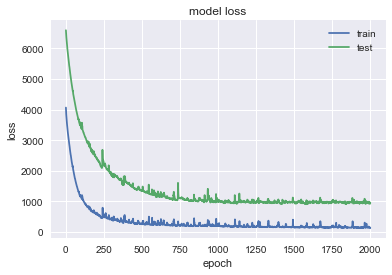

In [10]:
#stacked LSTMs
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(t_period))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.003))
# fit model
es = keras.callbacks.EarlyStopping(monitor='mean_squared_error', mode='min', verbose=1, patience=5)

history = model.fit(train_X, train_y, epochs=2000, batch_size=100, validation_data=(test_X, test_y), callbacks=[es], verbose=1, shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

def standardized_rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))
 
yhat = model.predict(test_X, verbose=0)
mape = mean_absolute_percentage_error(test_y, yhat)
rmse = standardized_rmse(test_y, yhat)
print('MAPE: %.3f' % mape)
print('Test Standardized RMSE: %.3f' % rmse)

MAPE: 3.145
Test Standardized RMSE: 30.827


Benchmark:

MAPE: 33.17

RMSE: 1907.62

Univariate:

MAPE 45.26

RMSE 1214.07

In [12]:
test_y.shape

(2470, 7)

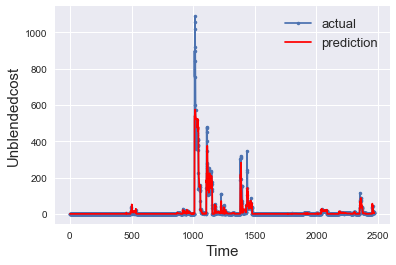

In [13]:
aa=[x for x in range(len(test_y))]
plt.plot(aa, test_y[:,-1], marker='.', label="actual")
plt.plot(aa, yhat[:,-1], 'r', label="prediction")
plt.ylabel('Unblendedcost', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=13)
plt.show()

In [ ]:
# big picture question:Need to understand one model for per product per perspective, how to use it to predict each product/per?
include the product & perspective as features. panel data regression - > investigate time series deep learning

# categorical data aggregation: not found online, use the mode for each feature now
use lambda function to produce a list, and then do one-hot encoding.
can try different statistics to see which one is more important.


# high cardinality categorical features: one-hot encoding is not ideal-too sparse, dimension reduction techniques: entity embedding, AutoEncoder...
needs a lot of data.simple PCA.take the top # that make up the #% cost 
resourceid, clustering analysis for cat vars.